In [1]:
from scipy.stats import truncnorm
import pandas as pd
import numpy as np
import itertools
import datetime
import tqdm
import sys
import os

import matplotlib.pyplot as plt

def flatten_list(list_array):
    return list(itertools.chain(*list_array))

sys.path.insert(0, "../../pompjax/pompjax/")
sys.path.insert(0, "../..")
sys.path.insert(0, "../")

from global_config import config

results_dir          = config.get_property('results_dir')
results2_dir         = config.get_property('results2_dir')
data_dir             = config.get_property('data_dir')
paper_dir            = config.get_property('paper_dir')
data_db_dir          = config.get_property('data_db_dir')

data_cluster_dir     = config.get_property('data_cluster_dir')
results_cluster_dir  = config.get_property('results_cluster_dir')

feb_hosp_records_path = os.path.join(data_db_dir, 'long_files_8_25_2021')
path_to_save          = os.path.join(results_dir, "real_testing", "community")


In [2]:
from utils_local import plot_utils
import matplotlib.ticker as ticker
import matplotlib.ticker as mtick
import seaborn as sns

path_to_results = "/Users/chaosdonkey06/Dropbox/shaman-lab/amr-hospitals2/results"
path_to_samples = os.path.join(path_to_results, "gamma_sensitivity")
infer_id        = str(0).zfill(3)

In [3]:
####-####-####-####-####-####-####-####-####-####-####
amro_search  = ['ESCHERICHIA COLI', 'KLEBSIELLA PNEUMONIAE',  'PSEUDOMONAS AERUGINOSA',
                'METHICILLIN-SUSCEPTIBLE STAPHYLOCOCCUS AUREUS',
                'ENTEROCOCCUS FAECALIS', 'ENTEROCOCCUS FAECIUM']

gammas                     = np.arange(0.3, 1+0.05, 0.05)[::-1]
experiments_df             = pd.DataFrame(columns=["amro", "gamma"])
experiments_df["scenario"] = list(np.arange(len(gammas))+1)*len(amro_search)
experiments_df["scenario"] = experiments_df["scenario"].apply(lambda x: f"scenario{x}")
experiments_df["gamma"]    = list(gammas)*len(amro_search)
experiments_df["amro"]     = flatten_list([[bug]*len(gammas) for bug in amro_search])


In [4]:
def empirical_prevalence(amro, path_to_prev="../data/amro_prevalence.csv"):
    amro_prev_df = pd.read_csv(path_to_prev)
    gammas       = amro_prev_df[amro_prev_df.amro==amro][["prevalence_mean1", "prevalence_mean2", "prevalence_mean3"]].values / 100
    return np.squeeze(gammas)


In [5]:


θ_all = np.full((len(amro_search), 15, 2, 300), np.nan)

id_run       = 0
posterior_df = pd.DataFrame()
for i_row, row in experiments_df.iterrows():

    amro         = row.amro
    samples_path = os.path.join(path_to_samples, amro, row.scenario)
    inference    = np.load(os.path.join(samples_path, "000posterior.npz"))

    θpost     = inference["posterior"]
    Nif       = θpost.shape[-1]

    ρ_post = θpost[0, :, :, :].mean(-2).flatten()
    β_post = θpost[1, :, :, :].mean(-2).flatten()

    g_index    = int(row.scenario.replace("scenario", ""))-1
    amro_index = amro_search.index(row.amro)

    θ_all[amro_index, g_index, 0, :] = θpost[0, :, :, :].mean(-2)[:, -1] * 100
    θ_all[amro_index, g_index, 1, :] = θpost[1, :, :, :].mean(-2)[:, -1]

    gammas = empirical_prevalence(amro, path_to_prev="../../data/amro_prevalence.csv")

    post_df                = pd.DataFrame(columns=["value", "param", "ens_id", "if_iter"])
    post_df["value"]       = np.concatenate([ρ_post, β_post])
    post_df["param"]       = ["ρ"] * len(ρ_post) + ["β"] * len(β_post)
    post_df["if_iter"]     = flatten_list([list(range(Nif)) * 300  ] * 2 )
    post_df["ens_id"]      = flatten_list([[i] * Nif for i in range( 300 )] * 2)
    post_df["gamma"]       = gammas[0] * row.gamma
    post_df["gamma_level"] = row.gamma
    post_df["amro"]        = row.amro
    posterior_df           = pd.concat([posterior_df, post_df])
v_df = posterior_df[posterior_df["if_iter"] == Nif-1]


In [6]:
amro_plot_df = pd.DataFrame()
for amro in amro_search:

    amro_df           = v_df[v_df.amro==amro]
    gammas            = amro_df["gamma"].unique()
    amro_df["gamma"]  = amro_df["gamma"].map(lambda x: "{:0.1f}%".format(x*100))
    amro_df["value"]  = amro_df.apply(lambda x: x["value"] * 100 if x["param"] == "ρ" else x["value"], axis=1)

    amro_q_df         = amro_df[["value", "param", "gamma", "gamma_level"]].groupby(["param", "gamma", "gamma_level"]).quantile(q=[1-0.05, 0.05]).reset_index().rename(columns={"level_3": "stat"})
    amro_q_df["stat"] = amro_q_df["stat"].replace( {1-0.05: "high95", 0.05: "low95"})
    amro_df           = amro_df[["value", "param", "gamma", "gamma_level"]].groupby(["param", "gamma", "gamma_level"]).mean()[["value"]].reset_index()

    amro_q_df["amro"] = amro
    amro_df["amro"]   = amro
    amro_df["stat"]   = "mean"

    amro_plot_df      = pd.concat([amro_plot_df, amro_df, amro_q_df[list(amro_df.columns)]])


/var/folders/20/x0sn0k_10hqfn739thwg8lxw0000gn/T/ipykernel_40765/803766434.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amro_df["gamma"]  = amro_df["gamma"].map(lambda x: "{:0.1f}%".format(x*100))
/var/folders/20/x0sn0k_10hqfn739thwg8lxw0000gn/T/ipykernel_40765/803766434.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amro_df["value"]  = amro_df.apply(lambda x: x["value"] * 100 if x["param"] == "ρ" else x["value"], axis=1)
/var/folders/20/x0sn0k_10hqfn739thwg8lxw0000gn/T/ipykernel_40765/803766434

In [22]:
COLORS_GAMMA = sns.color_palette("Greens", len(gammas)+3)[:-3]

Text(0.02, 0.5, 'importation rate, $\\mathbf{\\gamma}$ %')

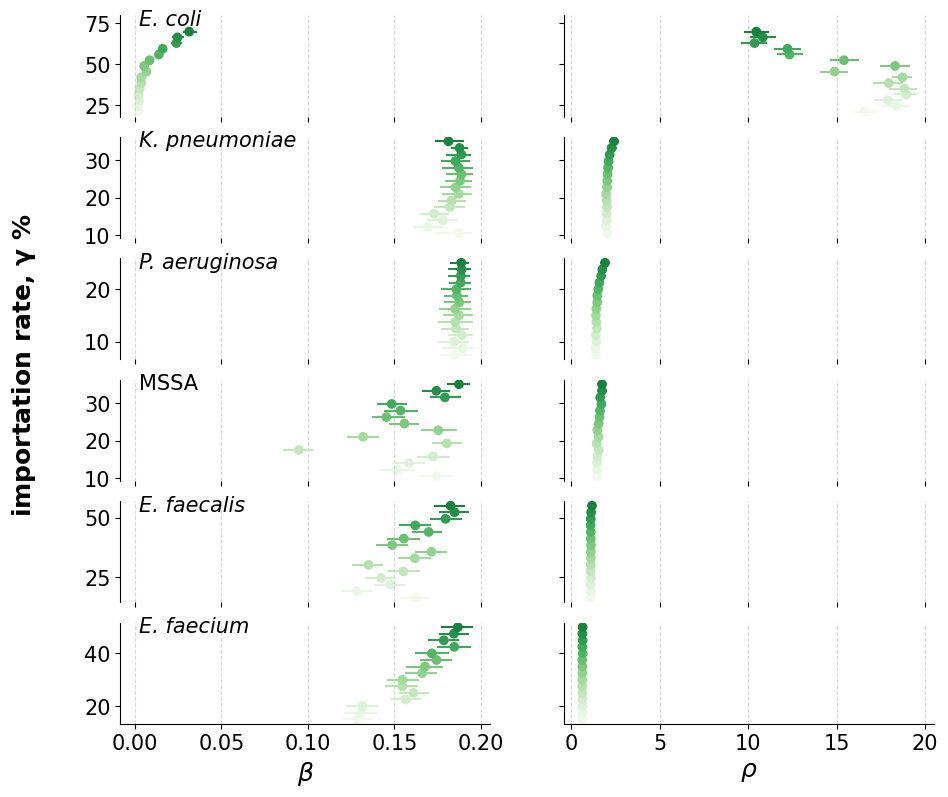

In [23]:
from utils_local.misc import amro2title, amro2cute

amro_df = amro_plot_df.query("amro=='{}'".format(amro_search[0]))

fig, ax = plt.subplots(len(amro_search), 2, figsize=(10.5, 9.2), sharey="row", sharex="col")

θ_mean = θ_all.mean(-1)
for i_amro, amro in enumerate(amro_search):

    gamma = empirical_prevalence(amro, path_to_prev="../../data/amro_prevalence.csv")
    y_axis = gamma[0] * np.arange(0.3, 1+0.05, 0.05) *100

    ### for ro
    quant = np.quantile(θ_all[i_amro, :, 0], q=[0.05, 0.95], axis=1)
    ax[i_amro, 1].hlines(y   = y_axis,
                        xmin = quant[1, :],
                        xmax = quant[0, :], color=COLORS_GAMMA)
    ax[i_amro, 1].scatter(θ_mean[i_amro, :, 0], y_axis, fc=COLORS_GAMMA, ec=None)


    ### for β
    quant = np.quantile(θ_all[i_amro, :, 1], q=[0.05, 0.95], axis=1)
    ax[i_amro, 0].hlines(y   = y_axis,
                        xmin = quant[1, :],
                        xmax = quant[0, :], color=COLORS_GAMMA)
    ax[i_amro, 0].scatter(θ_mean[i_amro, :, 1], y_axis, fc=COLORS_GAMMA, ec=None)

ax[0, 0].set_ylim((18, 80))

for axi in ax.flatten():
    axi.spines['right'].set_visible(False)
    axi.spines['top'].set_visible(False)

    axi.grid(axis="x", linestyle="--", alpha=0.5)

for i_amro in range(len(amro_search)-1):
    ax[i_amro, 0].spines["bottom"].set_visible(False)
    ax[i_amro, 1].spines["bottom"].set_visible(False)

for i_amro in range(len(amro_search)):
    if amro2title(amro_search[i_amro])!="MSSA":
        style = "italic"
    else:
        style = "normal"
    ax[i_amro, 0].text(s         = amro2title(amro_search[i_amro]),
                       x         = 0.05,
                       y         = 0.9,
                       transform = ax[i_amro, 0].transAxes,
                       style     = style)

ax[-1, 0].set_xlabel(r"$\beta$")
ax[-1, 1].set_xlabel(r"$\rho$")

fig.supylabel("importation rate, $\mathbf{\gamma}$ %", weight="bold")